In [4]:
#built-in
import os, warnings 

#data
import pandas as pd
import numpy as np

#preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

#metrics
#from sklearn.metrics import Auc, roc_curve,Confusion_matrix

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## Import dataset en convertissant les variable dans le bon format

In [5]:
df_Building_Energy_Benchmarking = pd.read_csv('2016_Building_Energy_Benchmarking.csv',
                                    index_col='OSEBuildingID', 
                                    dtype={'ZipCode':str,
                                          'CouncilDistrictCode':str})
df_Building_Energy_Benchmarking.shape

(3376, 45)

## Suppression des colonnes possedant trop de valeurs manquantes

In [6]:
df_X = df_Building_Energy_Benchmarking.loc[df_Building_Energy_Benchmarking.ComplianceStatus=='Compliant']\
.select_dtypes(np.number).copy()

df_X['Age'] = 2016-df_X.YearBuilt
df_X.drop(columns=['Comments','SecondLargestPropertyUseTypeGFA',
                   'ThirdLargestPropertyUseTypeGFA','YearBuilt','DataYear'],inplace=True)

In [7]:
df_X.head()

Latitude  Longitude  NumberofBuildings  NumberofFloors  \
OSEBuildingID                                                           
1              47.61220 -122.33799                1.0              12   
2              47.61317 -122.33393                1.0              11   
3              47.61393 -122.33810                1.0              41   
5              47.61412 -122.33664                1.0              10   
8              47.61375 -122.34047                1.0              18   

               PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
OSEBuildingID                                                                 
1                         88434                   0                   88434   
2                        103566               15064                   88502   
3                        956110              196718                  759392   
5                         61320                   0                   61320   
8                        175580               62000                  113580   

               LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
OSEBuildingID                                                                 
1                                88434.0             60.0         81.699997   
2                                83880.0             61.0         94.800003   
3                               756493.0             43.0         96.000000   
5                                61320.0             56.0        110.800003   
8                               123445.0             75.0        114.800003   

               ...  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
OSEBuildingID  ...                                               
1              ...            7226362.5              7456910.0   
2              ...            8387933.0              8664479.0   
3              ...           72587024.0             73937112.0   
5              ...            6794584.0              6946800.5   
8              ...           14172606.0             14656503.0   

               SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  \
OSEBuildingID                                                        
1                  2003882.00      1.156514e+06          3946027.0   
2                        0.00      9.504252e+05          3242851.0   
3                 21566554.00      1.451544e+07         49526664.0   
5                  2214446.25      8.115253e+05          2768924.0   
8                        0.00      1.573449e+06          5368607.0   

               NaturalGas(therms)  NaturalGas(kBtu)  TotalGHGEmissions  \
OSEBuildingID                                                            
1                     12764.52930         1276453.0             249.98   
2                     51450.81641         5145082.0             295.86   
3                     14938.00000         1493800.0            2089.28   
5                     18112.13086         1811213.0             286.43   
8                     88039.98438         8803998.0             505.01   

               GHGEmissionsIntensity  Age  
OSEBuildingID                              
1                               2.83   89  
2                               2.86   20  
3                               2.19   47  
5                               4.67   90  
8                               2.88   36  

[5 rows x 23 columns]

## Matrice de correlation

In [8]:
df_X.corr().style.background_gradient(cmap='Blues')

### Suppression des colonnes trop corrélée

In [9]:
df_X.drop(columns=['Electricity(kWh)','NaturalGas(therms)','SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)'],inplace=True)

### Données Manquantes

In [10]:
df_X.isna().sum()/df_X.shape[0]

Latitude                     0.000000
Longitude                    0.000000
NumberofBuildings            0.000934
NumberofFloors               0.000000
PropertyGFATotal             0.000000
PropertyGFAParking           0.000000
PropertyGFABuilding(s)       0.000000
LargestPropertyUseTypeGFA    0.004671
ENERGYSTARScore              0.252881
SiteEUI(kBtu/sf)             0.000000
SourceEUI(kBtu/sf)           0.001246
SiteEnergyUse(kBtu)          0.000000
SiteEnergyUseWN(kBtu)        0.000311
SteamUse(kBtu)               0.001246
Electricity(kBtu)            0.001246
NaturalGas(kBtu)             0.001246
TotalGHGEmissions            0.001246
GHGEmissionsIntensity        0.001246
Age                          0.000000
dtype: float64

In [12]:
df_X.dropna(inplace=True)
df_X.shape

(3195, 18)

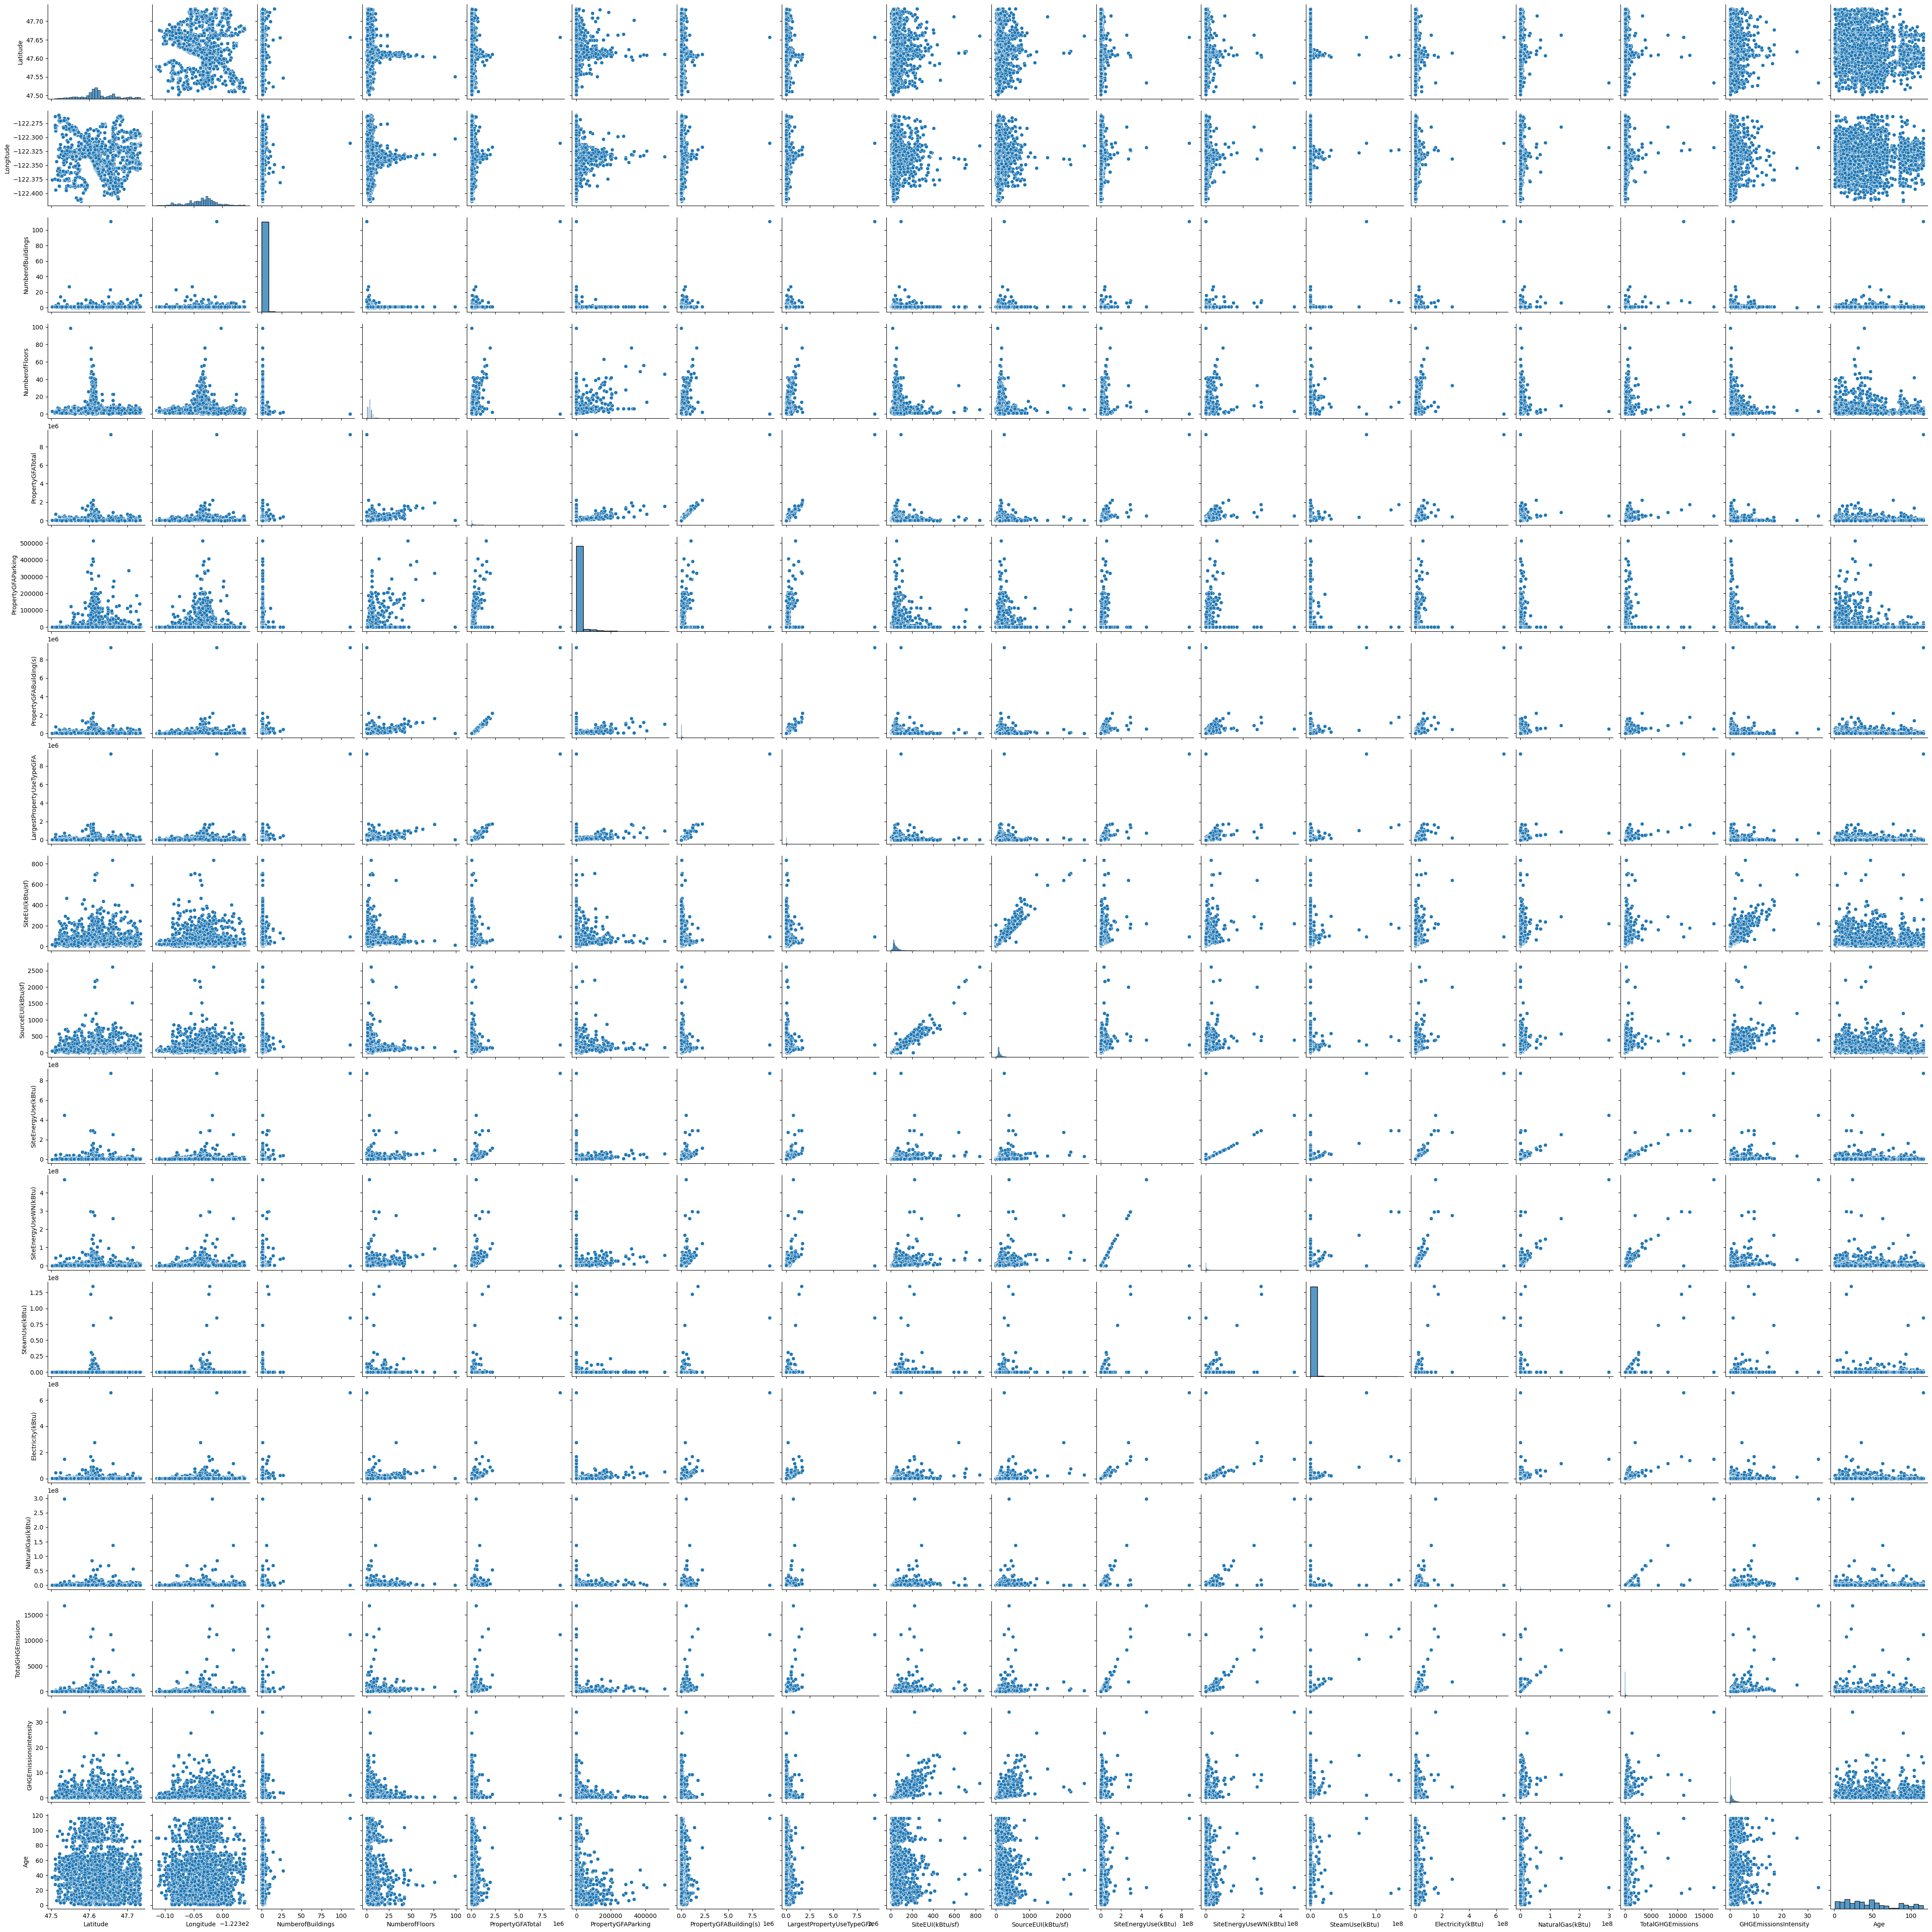

In [13]:
sns.pairplot(df_X)

## Outliers

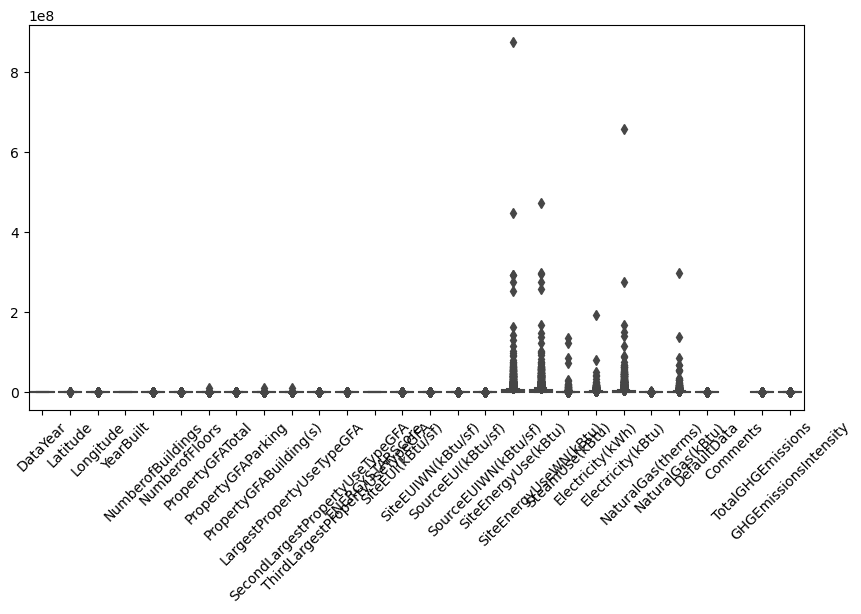

In [10]:
import seaborn as sns
fig = plt.figure(figsize=(10, 5))
sns.boxplot(data=df_Building_Energy_Benchmarking)
plt.xticks(rotation=45);

In [11]:
%%time
from sklearn.neighbors import LocalOutlierFactor

n_outliers = []
for i in range(2,150):
    clf = LocalOutlierFactor(n_neighbors=i)
    n_outliers.append( np.sum(clf.fit_predict(df_X.select_dtypes(np.number))==-1) )

CPU times: total: 1min 49s
Wall time: 15.2 s


In [12]:
min(n_outliers), np.argmin(n_outliers)

(168, 62)

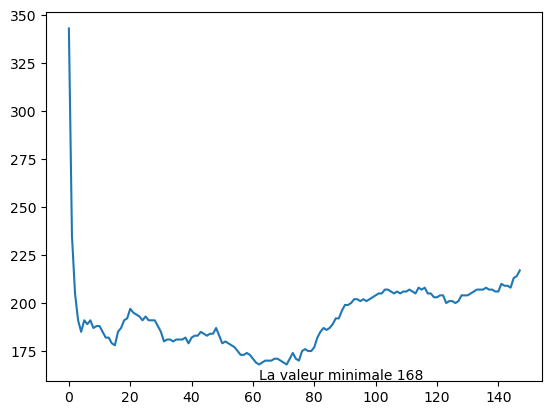

In [13]:
plt.plot(n_outliers)
plt.text(x = np.argmin(n_outliers),y = 160,s='La valeur minimale {}'.format(min(n_outliers)))
plt.show()

##### suppression des lignes de Outliers

In [14]:
clf = LocalOutlierFactor(n_neighbors=np.argmin(n_outliers))
df_X = df_X.loc[clf.fit_predict(df_X.select_dtypes(np.number))==1]

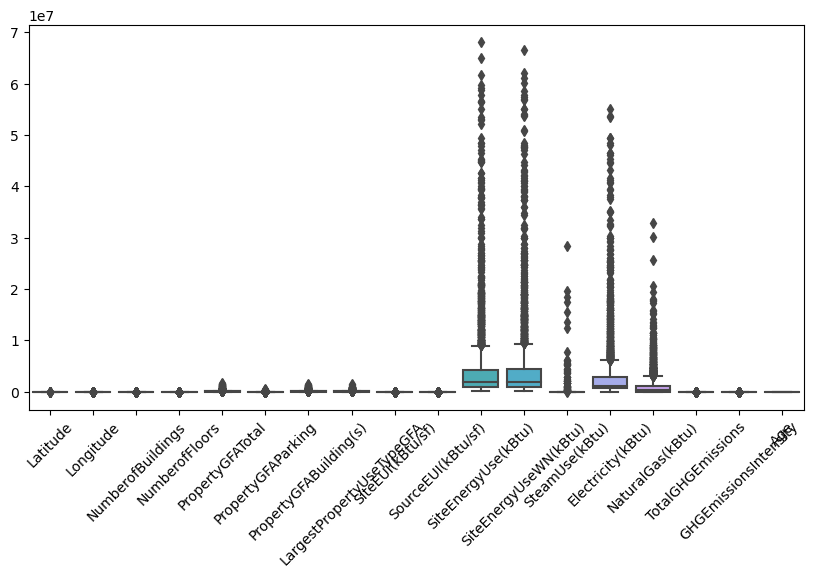

In [15]:
import seaborn as sns
fig = plt.figure(figsize=(10, 5))
sns.boxplot(data=df_X)
plt.xticks(rotation=45);

In [16]:
df_X.shape

(3024, 18)

## Preposessing

In [17]:
X = df_X[[x for x in df_X.columns if 'TotalGHGEmissions'!=x]].values
y = df_X.TotalGHGEmissions.values

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomTransformerytology(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, y, X=None):
        return self
    
    def transform(self, y, X=None):
        # Perform arbitary transformation
        return np.log1p(y)

In [19]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, CustomTransformerytology().transform(y), 
                                                    test_size=0.33, random_state=42)

from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler().fit(X_train)
X_train_scaled = Scaler.transform(X_train)
X_test_scaled = Scaler.transform(X_test)

Calcul score a battre

In [20]:
# Naif uniform estiamtor

import sklearn as sk
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_squared_log_error
from sklearn.metrics import get_scorer,make_scorer

class DummyUniform(sk.base.BaseEstimator):
    """prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes.
    """

    def __init__(self):
        self.y = y
        self.X = X

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X, y):
        #X, y = check_X_y(X, y)
        self.y_min = np.min(self.y)
        self.y_max = np.max(self.y)
        self.size = self.X.shape[0]
        return self

    def predict(self, X,y=None):
        return np.random.randint(self.y_min, self.y_max,X.shape[0] )
    
    def score(self, X,y,metric = 'r2'):
        if metric=='r2':
            return r2_score(y,np.random.randint(self.y_min, self.y_max,X.shape[0] ))
        elif metric.lower() == 'neg_mean_squared_error' | metric.lower() == 'mean_squared_error':
            return -mean_squared_error(y,np.random.randint(self.y_min, self.y_max,X.shape[0] ))
        elif metric.lower() == 'neg_mean_absolute_error' | metric.lower() == 'mean_absolute_error':
            return -mean_absolute_error(y,np.random.randint(self.y_min, self.y_max,X.shape[0] ))
        elif metric.lower() == 'RMSE' | metric.lower() == 'mean_absolute_error':
            return mean_squared_error(y,np.random.randint(self.y_min, self.y_max,X.shape[0] ))

In [21]:
def result_score(TypeScore,score,strategie):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        TypeScore,
        np.mean(score),
        np.std(score)**2,
        strategie
    ) )

In [22]:
from sklearn import dummy

naifMean = dummy.DummyRegressor(strategy='mean')
naifMedian = dummy.DummyRegressor(strategy='median')
naifUniform = DummyUniform()

from sklearn.model_selection import cross_val_score
meanNaifCV = cross_val_score(naifMean,X_train_scaled,y_train,scoring="r2")
medianNaifCV = cross_val_score(naifMedian,X_train_scaled,y_train,scoring="r2")
uniformNaifCV = cross_val_score(naifUniform,X_train_scaled,y_train,scoring="r2")

In [23]:
result_score("R2",meanNaifCV,'dummyMean')
result_score("R2",medianNaifCV,'dummyMedian')
result_score("R2",uniformNaifCV,'Uniform')

R2 = -0.001 (+/-0.000) for dummyMean
R2 = -0.001 (+/-0.000) for dummyMedian
R2 = -1189269.286 (+/-10053631214.439) for Uniform


### Regression lineaire

In [24]:
from sklearn.linear_model import LinearRegression
regl = LinearRegression()
regl.fit(X_train_scaled,y_train)

#Evaluation des resultats
result_score("R2",cross_val_score(regl,X_train_scaled,y_train,scoring="r2"),'linear Regression ')

baseline_error = np.mean((regl.predict(X_test_scaled) - y_test) ** 2)
print("MSE :",baseline_error)

R2 = 0.635 (+/-0.004) for linear Regression 
MSE : 0.6040835577229612


In [25]:
import shap

shap.initjs()

In [26]:
lin_reg_explainer1 = shap.LinearExplainer(regl, X_train_scaled)

In [27]:
sample_idx = 0

shap_vals = lin_reg_explainer1.shap_values(X_test_scaled[sample_idx])

print("Expected/Base Value : ", lin_reg_explainer1.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", regl.predict(X_test_scaled[sample_idx].reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value : ", lin_reg_explainer1.expected_value + shap_vals.sum())

Expected/Base Value :  3.419357548460451

Shap Values for Sample 0 :  [-5.53161227e-02 -9.69889763e-02  6.72437920e-04 -3.47873298e-02
 -7.01279426e-02  6.45265239e-03 -8.83951402e-02 -8.34620160e-02
  3.50439359e-02  1.64255684e-02  8.99276792e-01 -6.58701624e-01
 -3.96783463e-02 -1.70270763e-01 -1.18908147e-01  6.79390417e-02
  1.98579383e-03]


Prediction From Model                            :  3.030517362151727
Prediction From Adding SHAP Values to Base Value :  3.030517362151727


In [28]:
lin_reg_explainer2 = shap.LinearExplainer(regl, X_train_scaled, feature_perturbation="correlation_dependent")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

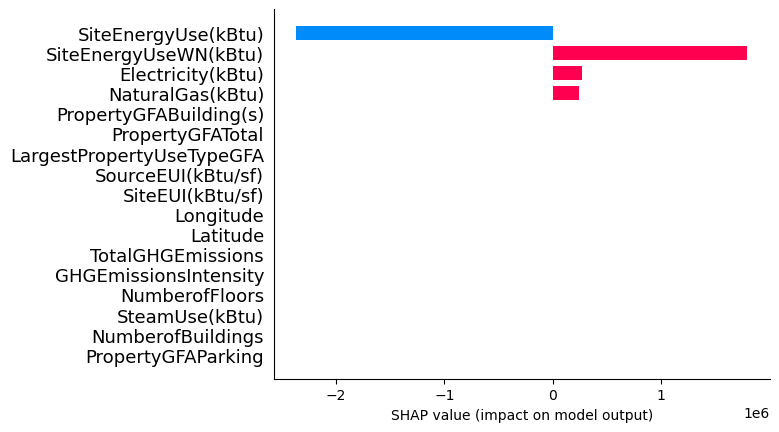

In [29]:
shap.bar_plot(lin_reg_explainer1.shap_values(X_test[0]),
              feature_names=df_X.columns,
              max_display=len(df_X.columns))

#### Waterfall Plot

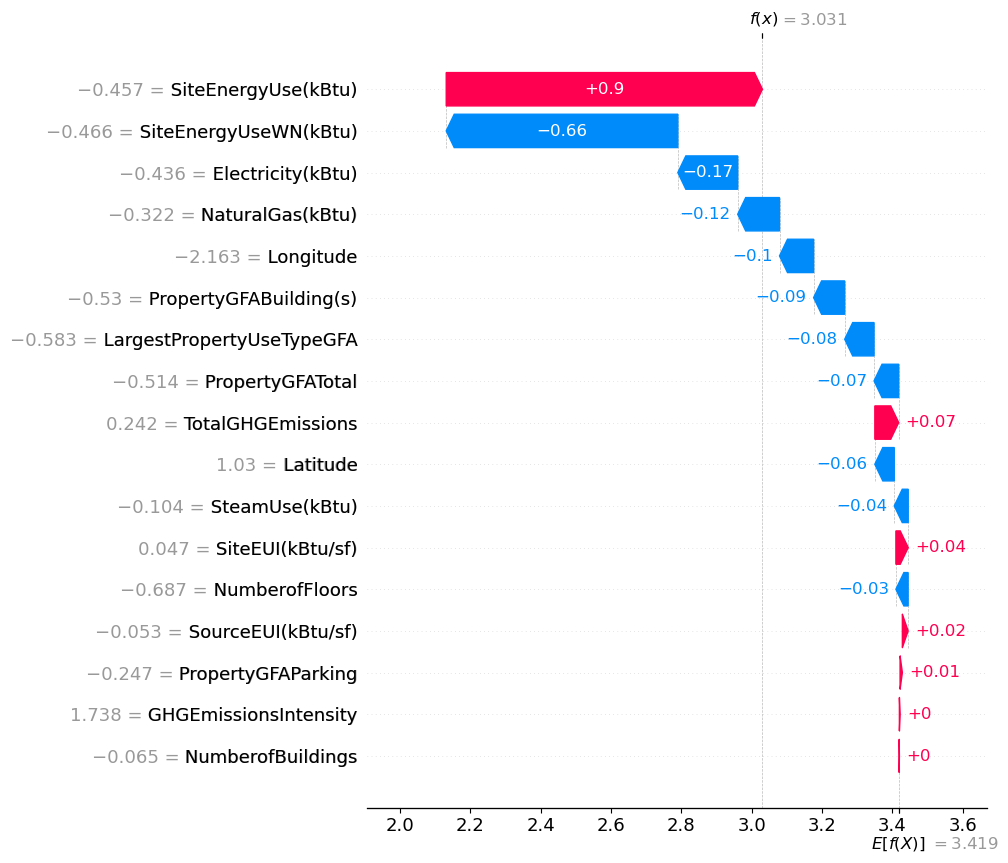

In [30]:
shap_values = lin_reg_explainer1(X_test_scaled[:1])
shap_values.feature_names = df_X.columns

shap.waterfall_plot(shap_values[0], max_display=len( df_X.columns))

#### Decision Plot

In [31]:
features = df_X.columns.to_list()
features.remove('TotalGHGEmissions')

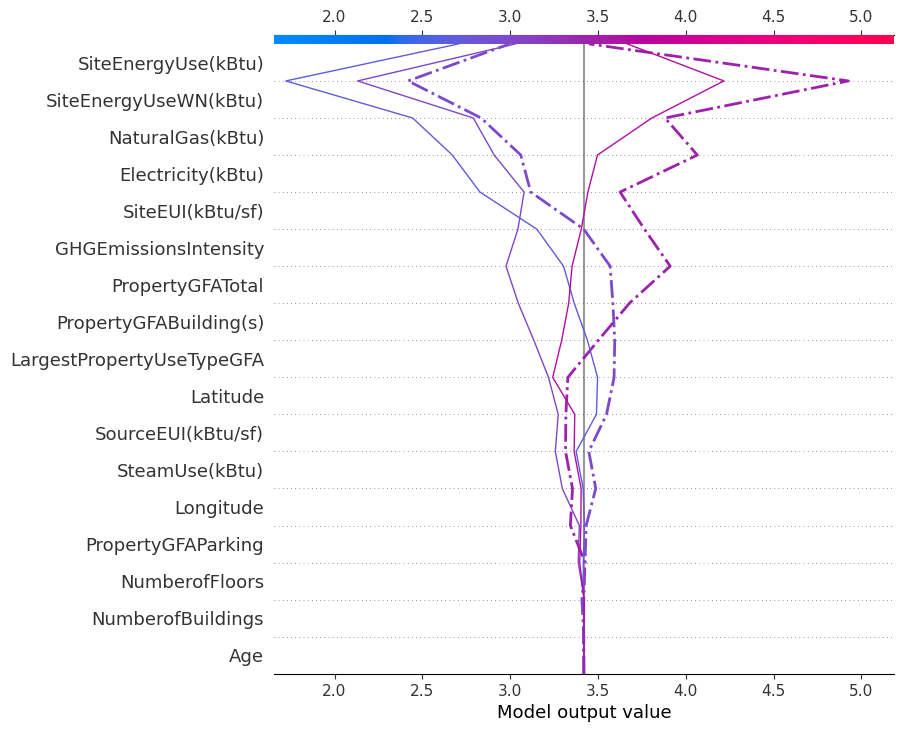

In [32]:
shap.decision_plot(lin_reg_explainer1.expected_value,
                   lin_reg_explainer1.shap_values(X_test_scaled[0:5]),
                   feature_names=features,
                   highlight=[1, 2],
                   )

#### Dependence Plot

In [33]:
features = df_X.columns.to_list()
features.remove('TotalGHGEmissions')

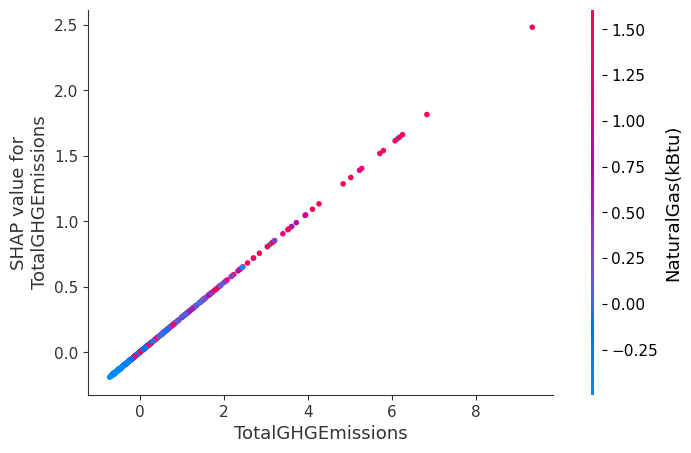

In [34]:
shap.dependence_plot("TotalGHGEmissions",
                     lin_reg_explainer1.shap_values(X_test_scaled),
                     features=X_test_scaled,
                     feature_names=df_X.columns,
                     )

#### Embedding Plot

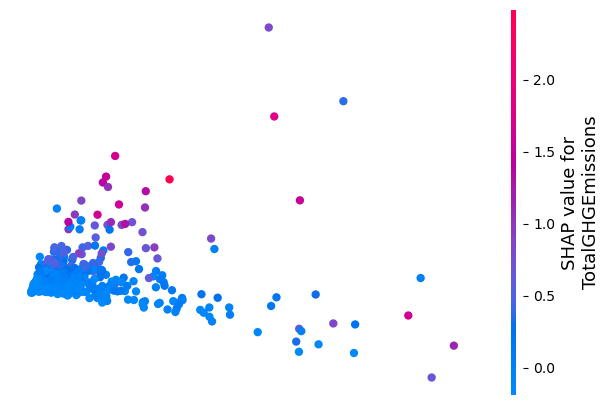

In [35]:
shap.embedding_plot("TotalGHGEmissions",
                    lin_reg_explainer1.shap_values(X_test_scaled),
                    feature_names=df_X.columns)

#### Force Plot

In [36]:
features = df_X.columns.to_list()
features.remove('TotalGHGEmissions')
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test_scaled[0]),
                feature_names=features,
                out_names="CO₂"
               )

In [37]:
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test_scaled[0:10]),
                feature_names=features,
                out_names="CO₂", figsize=(25,3),
                link="identity")

#### Summary Plot

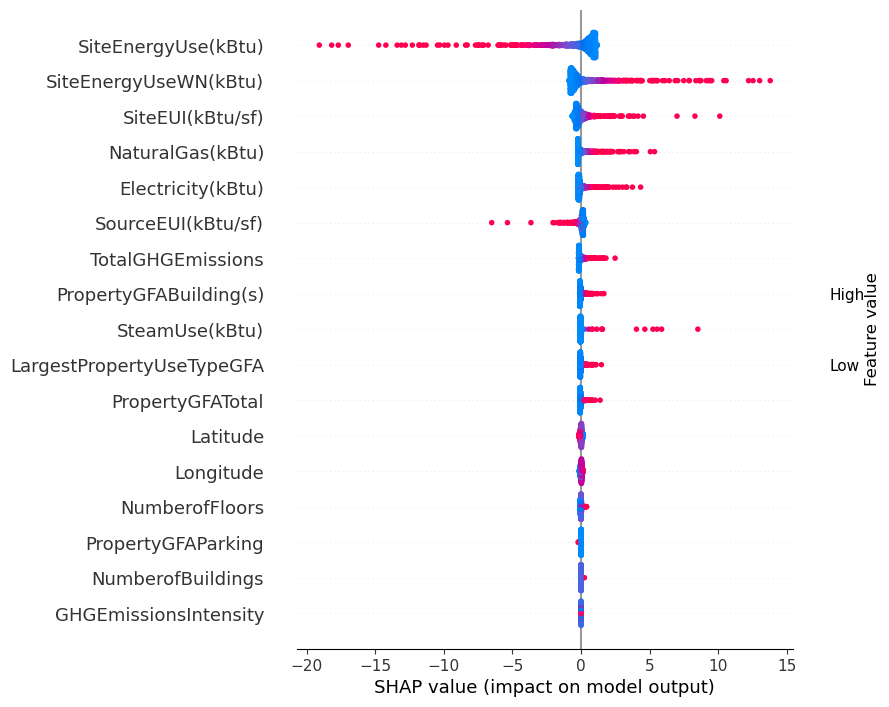

In [38]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test_scaled),
                  features = X_test_scaled,
                  feature_names=df_X.columns)

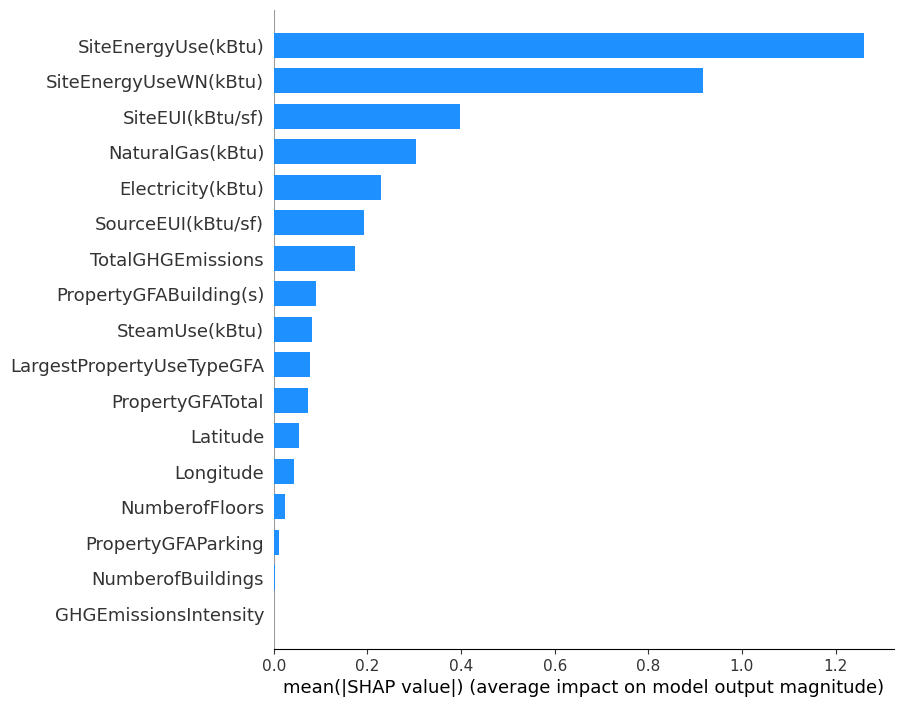

In [39]:
shap.summary_plot(lin_reg_explainer1.shap_values(X_test_scaled),
                  features = X_test_scaled,
                  feature_names=df_X.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )

#### Partial Dependence Plot

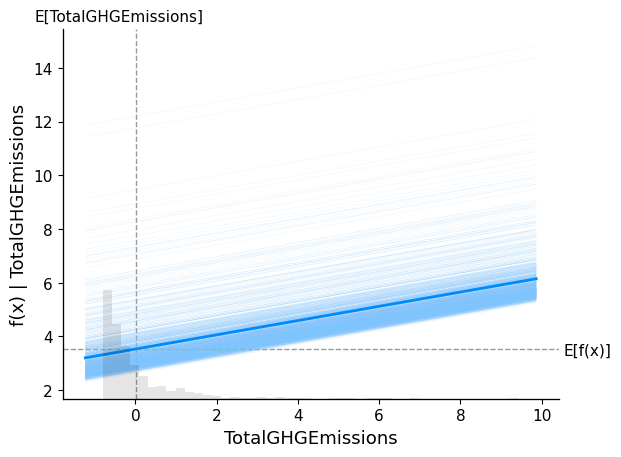

In [40]:
shap.partial_dependence_plot("TotalGHGEmissions",
                             regl.predict,
                             data=X_test_scaled,
                             feature_names=df_X.columns,
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True
                             )

### Importance des varibles(Features)

In [41]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regl, X_test_scaled,y_test,n_repeats=30,random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_X.columns[i]:<50}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

SiteEnergyUse(kBtu)                               6.388 +/- 0.262
SiteEnergyUseWN(kBtu)                             3.198 +/- 0.126
SiteEUI(kBtu/sf)                                  0.592 +/- 0.028
NaturalGas(kBtu)                                  0.342 +/- 0.015
Electricity(kBtu)                                 0.225 +/- 0.013
SourceEUI(kBtu/sf)                                0.217 +/- 0.013
SteamUse(kBtu)                                    0.124 +/- 0.012
TotalGHGEmissions                                 0.068 +/- 0.007
PropertyGFABuilding(s)                            0.039 +/- 0.004
LargestPropertyUseTypeGFA                         0.030 +/- 0.003
PropertyGFATotal                                  0.030 +/- 0.003
Latitude                                          0.005 +/- 0.002


In [42]:
df_X.columns

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'Age'],
      dtype='object')

In [43]:
regl.predict(X_test_scaled[:1])

array([3.03051736])

### Regression Ridge

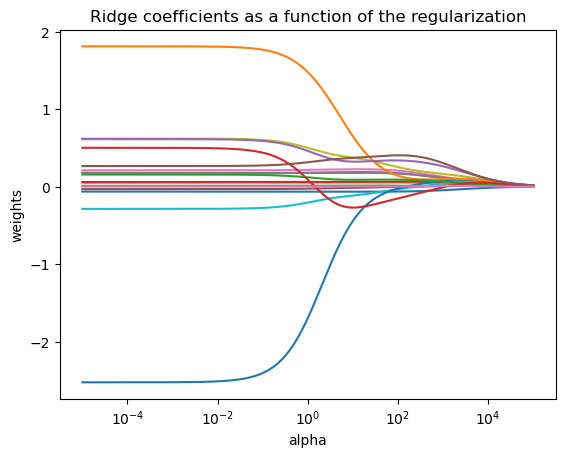

In [44]:
from sklearn.linear_model import Ridge
regRidge = Ridge()

alphas1 = np.logspace(-5, 5, 2000)
coefs1 = []
errors1 = []

for a in alphas1:
    regRidge.set_params(alpha=a)
    regRidge.fit(X_train_scaled, y_train)
    coefs1.append(regRidge.coef_)
    errors1.append([baseline_error, np.mean((regRidge.predict(X_test) - y_test) ** 2)])

    
import matplotlib.pyplot as plt
ax = plt.gca()

ax.plot(alphas1, coefs1)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

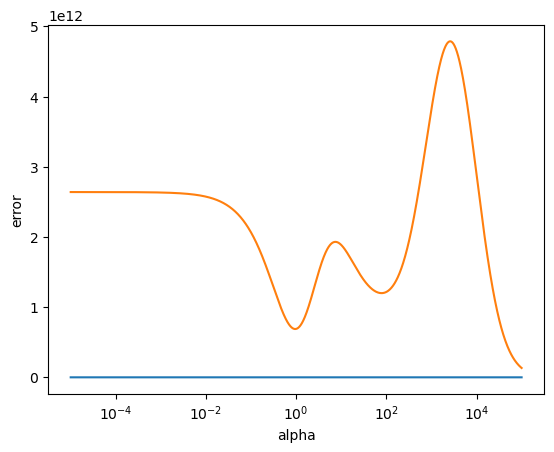

In [45]:
ax = plt.gca()

ax.plot(alphas1, errors1)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

#### GridSearch

In [46]:
%%time
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.linear_model import Ridge

inner_cv = KFold(n_splits=5,shuffle=True,random_state=0)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=1)

model = GridSearchCV(estimator=Ridge(), param_grid={"alpha":np.logspace(-20, 20, 400),
                                                   "fit_intercept":[True,False]},
                     cv=inner_cv, n_jobs=2,scoring='r2')

outer_scoreRidge = cross_val_score(model,X=X_train_scaled,y=y_train,cv=outer_cv,n_jobs=2,scoring='r2')

print(f"The mean score using nested cross-validation is: "
      f"{outer_scoreRidge.mean():.3f} ± {outer_scoreRidge.std():.3f}")

The mean score using nested cross-validation is: 0.638 ± 0.027
CPU times: total: 46.9 ms
Wall time: 23.3 s


In [47]:
model.fit(X_train_scaled,y_train)
print(f"The best parameters found are: {model.best_params_}")

The best parameters found are: {'alpha': 226.9288562880067, 'fit_intercept': True}


#### GridSearch

In [48]:
## Best model
regRidgeBest = Ridge()
regRidgeBest.set_params(alpha= 231.0371618711771, fit_intercept= True)

#Evaluation des resultats
result_score("R2",cross_val_score(regRidgeBest,X_train_scaled,y_train,scoring="r2"),'Ridge Regression ')

R2 = 0.655 (+/-0.001) for Ridge Regression 


In [49]:
from sklearn.linear_model import Ridge,RidgeCV
regRidge = RidgeCV(alphas=np.logspace(-5,5,2000)).fit(X_train_scaled, y_train)
print("Train dataset {:.3f}".format(regRidge.score(X_train_scaled, y_train) ))
print("Test dataset {:.3f}".format(regRidge.score(X_test_scaled, y_test) ))
print("Best parametre Alpha: {}".format(regRidge.alpha_))

Train dataset 0.669
Test dataset 0.665
Best parametre Alpha: 150.8652770522709


</br>

</br>

### Regression LASSO

In [50]:
%%time
from sklearn.linear_model import Lasso,LassoCV

alphas2 = np.logspace(-20, 20, 50)
lasso = Lasso(max_iter=100000,normalize = True)

coefs2 = []
errors2 = []
for a in alphas2:
    warnings.filterwarnings(action='once')
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs2.append(lasso.coef_)
    errors2.append([baseline_error, np.mean((lasso.predict(X_test_scaled) - y_test) ** 2)])

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.961e+02, tolerance: 3.735e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
'normalize' was depre

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+01, tolerance: 3.735e-01
'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+01, tolerance: 3.735e-01
'normaliz

CPU times: total: 3min 9s
Wall time: 48.2 s


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each s

#### GridSearch

In [51]:
%%time
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.linear_model import Lasso

inner_cv = KFold(n_splits=5,shuffle=True,random_state=0)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=1)

model2 = GridSearchCV(estimator=Lasso(), 
                      param_grid={"alpha":np.logspace(-20, 20, 400), "fit_intercept":[True,False]},
                      cv=inner_cv, 
                      n_jobs=2,
                      scoring='r2')

outer_scoreLasso = cross_val_score(model2,X=X_train_scaled,y=y_train,cv=outer_cv,n_jobs=3,scoring='r2')

print(f"The mean score using nested cross-validation is: "
      f"{outer_scoreLasso.mean():.3f} ± {outer_scoreLasso.std():.3f}")


The mean score using nested cross-validation is: 0.624 ± 0.035
CPU times: total: 438 ms
Wall time: 59.2 s


## ElasticNetCV

Computing regularization path using the elastic net...


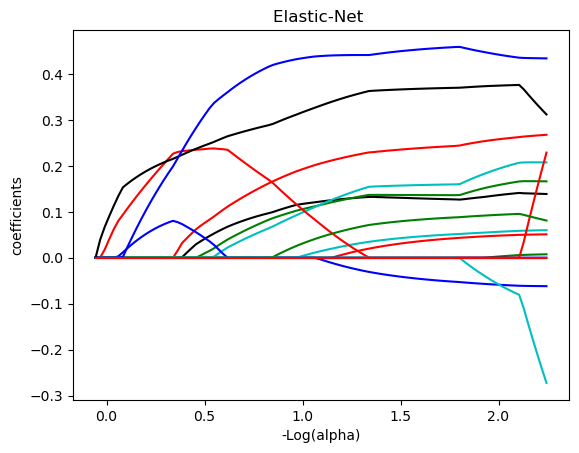

CPU times: total: 688 ms
Wall time: 189 ms


In [52]:
%%time
from sklearn.linear_model import ElasticNetCV,ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X_train_scaled,y_train, eps=eps, l1_ratio=0.8)

colors = cycle(["b", "r", "g", "c", "k"])

neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet,  colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic-Net ")
#plt.legend((l1[-1], "Elastic-Net", loc="lower left")
plt.axis("tight")
plt.show()

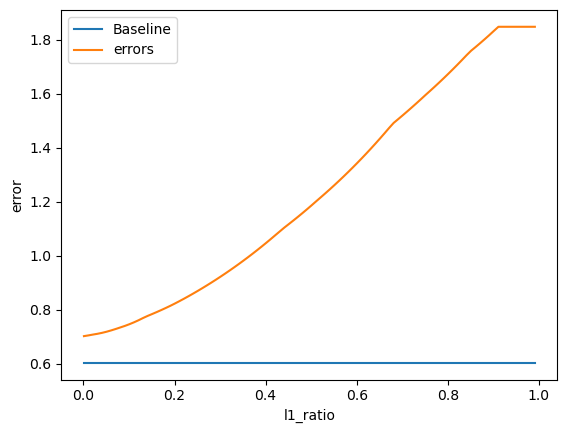

In [53]:
l1_ratio_p = np.arange(0.001,0.999,0.01)
elasNet = ElasticNet(max_iter=10000,normalize=True)

coefs3 = []
errors3 = []
for l1_r in l1_ratio_p:
    elasNet = ElasticNet(max_iter=10000,l1_ratio=l1_r)
    elasNet.fit(X_train_scaled, y_train)
    coefs3.append(elasNet.coef_)
    errors3.append([baseline_error, np.mean((elasNet.predict(X_test_scaled) - y_test) ** 2)])
    
ax = plt.gca()
ax.plot(l1_ratio_p, errors3)
plt.xlabel('l1_ratio')
plt.ylabel('error')
plt.axis('tight')
plt.legend( ["Baseline","errors"], loc="upper left")
plt.show()

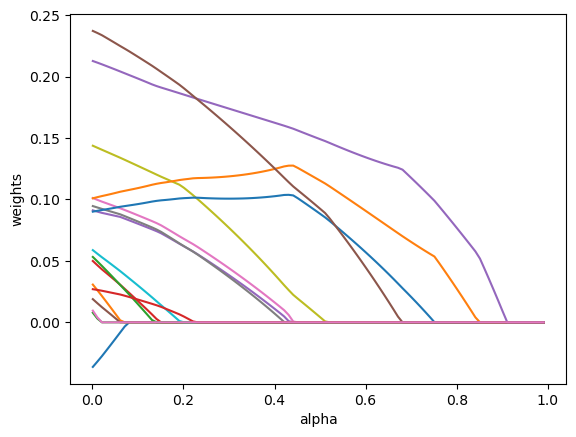

In [54]:
ax = plt.gca()

ax.plot(l1_ratio_p, coefs3)
#ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

### Representation des Score des 3 model en fonction d'Alpha 

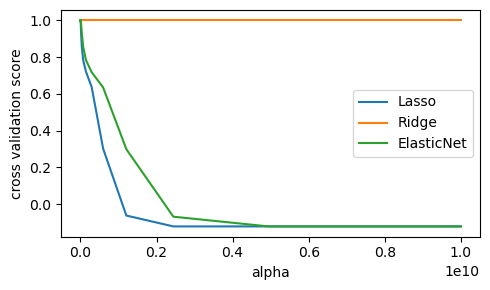

In [55]:
import numpy as np
from matplotlib import pyplot as plt

alphas = np.logspace(-5, 10, 50)

plt.figure(figsize=(5, 3))

for Model in [Lasso, Ridge,ElasticNet]:
    scores = [cross_val_score(Model(alpha), X, y, cv=3,n_jobs=-3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

    
plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
#plt.set_xscale('log')
plt.tight_layout()
plt.show()

### Machine à Vecteur de Support Regression

In [56]:
X_train_scaled[:50].shape

(50, 17)

#### GridSearch Polynomial

#### GridSearch RBF

In [57]:
%%time
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

gamma_to_test = np.logspace(-3,3,5)

inner_cv = KFold(n_splits=5,shuffle=True,random_state=0)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=1)

params_grid = {
               'gamma': gamma_to_test,
               }

modelRBF = GridSearchCV(estimator=SVR(kernel='rbf'), 
                      param_grid=params_grid,
                      cv=inner_cv, 
                      n_jobs=4,
                      scoring='r2')

#model2.fit(X_train_scaled,y_train)
#non_nested_score = model2.best_score_
nested_score_svr = cross_val_score(modelRBF,X=X_train_scaled,y=y_train,cv=outer_cv,n_jobs=1,scoring='r2')

nested_score_svr.mean()

CPU times: total: 859 ms
Wall time: 8.46 s


0.9506034887409746

#### GridSearch Sigmoid

In [58]:
%%time
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

inner_cv = KFold(n_splits=5,shuffle=True,random_state=0)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=1)

params_grid = {
               'coef0':[0,0.5,1],
               'gamma': np.logspace(-1,2,4),
               }

modelSIGMOID = GridSearchCV(estimator=SVR(kernel='sigmoid'), 
                      param_grid=params_grid,
                      cv=inner_cv, 
                      n_jobs=4,
                      scoring='r2')

#model2.fit(X_train_scaled,y_train)
#non_nested_score = model2.best_score_
nested_score_svr = cross_val_score(modelSIGMOID,X=X_train_scaled,y=y_train,cv=outer_cv,n_jobs=1,scoring='r2')

nested_score_svr.mean()

CPU times: total: 1.16 s
Wall time: 12.4 s


-783.8667498619714

#### GridSearch Lineaire

In [59]:
%%time
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

inner_cv = KFold(n_splits=5,shuffle=True,random_state=0)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=1)

params_grid = {#'kernel':('poly', 'rbf', 'sigmoid'),
               #'degree':[2,3],
               #'coef0':[0,0.5,1],
               'C':[0.5,1,2],
               #'gamma': np.logspace(-9,-5,4,13),
               #'epsilon':[0.1,0.2,0.5,0.3]
               }

modelLinear = GridSearchCV(estimator=SVR(kernel = 'linear'), 
                      param_grid=params_grid,
                      cv=inner_cv, 
                      n_jobs=3,
                      scoring='r2')

#model2.fit(X_train_scaled,y_train)
#non_nested_score = model2.best_score_
nested_score_svr = cross_val_score(modelLinear,X=X_train_scaled,y=y_train,cv=outer_cv,n_jobs=2,scoring='r2')

nested_score_svr.mean()

CPU times: total: 62.5 ms
Wall time: 8.33 s


0.5208966446997915

</br>

## RandomForest

In [60]:
%%time
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 

inner_cv = KFold(n_splits=5,shuffle=True,random_state=0)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=1)

params_grid = {'max_depth':[None,2,5,10],
               'max_features':['sqrt', 'log2',1],
               }

modelRF = GridSearchCV(estimator=RandomForestRegressor(oob_score = True,n_jobs = -2), 
                      param_grid=params_grid,
                      cv=inner_cv, 
                      n_jobs=1,
                      scoring='r2')

#model2.fit(X_train_scaled,y_train)
#non_nested_score = model2.best_score_
nested_score_svr = cross_val_score(modelRF,X=X_train_scaled,y=y_train,cv=outer_cv,n_jobs=1,scoring='r2')

nested_score_svr.mean()

CPU times: total: 40.6 s
Wall time: 45.5 s


0.9947778244542101

In [61]:
%whos

Variable                          Type                  Data/Info
-----------------------------------------------------------------
BaseEstimator                     type                  <class 'sklearn.base.BaseEstimator'>
CustomTransformerytology          type                  <class '__main__.CustomTransformerytology'>
DummyUniform                      type                  <class '__main__.DummyUniform'>
ElasticNet                        ABCMeta               <class 'sklearn.linear_mo<...>nate_descent.ElasticNet'>
ElasticNetCV                      ABCMeta               <class 'sklearn.linear_mo<...>te_descent.ElasticNetCV'>
GridSearchCV                      ABCMeta               <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
KFold                             ABCMeta               <class 'sklearn.model_selection._split.KFold'>
Lasso                             ABCMeta               <class 'sklearn.linear_mo<...>oordinate_descent.Lasso'>
LassoCV                           AB

In [62]:
sk.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_